### Vector Dataset Class

The code defines a hierarchical structure for geospatial datasets, with GeoDataset as a base class providing transformation capabilities for its subclasses, and VectorDataset extending it to specifically handle vector data. VectorDataset is designed to manage and process geospatial vector data, supporting operations like reading data from specified paths, handling coordinate reference systems (CRS), and optionally applying transformations to the data. The StormwaterDataset subclass further specializes VectorDataset for a specific dataset, demonstrating how the framework can be tailored to specific types of geospatial data, such as stormwater data contained within a GeoDatabase file.

In [2]:
import os
import re
import sys
import fiona
from typing import Union, Optional, Callable, Any, Iterable
from pyproj import CRS, Transformer
from shapely.geometry import shape, mapping
import numpy as np
import rasterio.features
from rasterio.transform import from_bounds
from torchgeo.datasets import GeoDataset, VectorDataset

In [4]:
DATA_ROOT = "/net/projects/cmap/data"
KC_SHAPE_ROOT = os.path.join(DATA_ROOT, "kane-county-data")
KC_IMAGE_ROOT = os.path.join(DATA_ROOT, "KC-images")
KC_MASK_ROOT = os.path.join(DATA_ROOT, "KC-masks/top-structures-masks")
KC_MASK_VEC_ROOT = os.path.join(DATA_ROOT, "KC-masks/top-structures-masks-vec")

In [3]:
class KaneCounty(VectorDataset):
    filename_glob = "mask_m*.tif"
    filename_regex = r"""
        ^mask_m
        _(?P<quadrangle>\d+)
        _(?P<quarter_quad>[a-z]+)
        _(?P<utm_zone>\d+)
        _(?P<resolution>\d+)
        _(?P<date>\d+)
        (?:_(?P<processing_date>\d+))?
        \..*$
    """

    label_names = {
        1: "POND",
        2: "WETLAND",
        3: "DRY BOTTOM - TURF",
        4: "DRY BOTTOM - MESIC PRAIRIE",
        5: "DEPRESSIONAL STORAGE",
        6: "DRY BOTTOM - WOODED",
        7: "POND - EXTENDED DRY",
        8: "PICP PARKING LOT",
        9: "DRY BOTTOM - GRAVEL",
        10: "UNDERGROUND",
        11: "UNDERGROUND VAULT",
        12: "PICP ALLEY",
        13: "INFILTRATION TRENCH",
        14: "BIORETENTION",
        15: "UNKNOWN",
    }

    labels_inverse = {v: k for k, v in label_names.items()}


In [4]:
# Attempt to load the county data using the mask root
dataset = KaneCounty(paths= KC_MASK_ROOT)

FileNotFoundError: No KaneCounty data was found in `root='/net/projects/cmap/data/KC-masks/top-structures-masks'`

The error encountered while attempting to load these TIFF files is due to the format not being compatible or readable by Fiona. Fiona, being a Python library for reading and writing vector data, primarily supports formats like GeoJSON, ESRI Shapefile, and others that are often used in GIS applications. The TIFF files listed (e.g., mask_m_4108804_ne_16_060_20210928.tif, mask_m_4108812_nw_16_060_20210928.tif, etc.) are raster files, not vector data, which is likely why Fiona is throwing a FionaValueError. This error is specifically designed to handle situations where the provided input does not match the expected format or contains values that Fiona cannot process. In this case, we might need to consider convert the raster file to the vector dataset in order to correcly load the above code.

### Convert raster mask to vector mask

The below code attempt to convert the raster mask data into the vector data in order to be loaded in the VectorDataset class.



In [10]:
import os
import rasterio
from rasterio.features import shapes
import geopandas as gpd
from shapely.geometry import shape

def convert_raster_to_vector(tif_path, output_directory=None):
    """"
    Converts a raster TIFF file to a vector Shapefile.

    Args:
    tif_path (str): The file path of the raster TIFF to be converted.
    output_directory (str, optional): The directory where the Shapefile will be saved.
                                      If None, uses the TIFF file's directory.

    Returns:
    str: The file path of the created Shapefile.
    """
    # Extract base name from the TIFF path
    base_name = os.path.splitext(os.path.basename(tif_path))[0]

    # Define the output Shapefile path
    shp_path = os.path.join(output_directory, f"{base_name}.shp")

    # Ensure the output directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Step 1: Read the raster data
    with rasterio.open(tif_path) as src:
        image = src.read(1)  # Assume we're interested in the first band
        # Convert non-zero values to True, zeros to False (adjust as needed)
        mask = image != 0

        # Step 2: Vectorize the mask
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(image, mask=mask, transform=src.transform))
        )

    # Step 3: Create a GeoDataFrame from the shapes
    gdf = gpd.GeoDataFrame.from_features(list(results))

    # Set CRS for the GeoDataFrame using the raster's CRS
    gdf.crs = src.crs

    # Save the GeoDataFrame to a new Shapefile
    gdf.to_file(shp_path, driver='ESRI Shapefile')

    return shp_path


In [11]:
# Example usage
tif_file_path = os.path.join(KC_MASK_ROOT, "mask_m_4108804_ne_16_060_20210928.tif")
output_dir = KC_MASK_VEC_ROOT
shp_file_path = convert_raster_to_vector(tif_file_path, output_directory=output_dir)
print(f"Shapefile saved to: {shp_file_path}")

Shapefile saved to: /net/projects/cmap/data/KC-masks/top-structures-masks-vec/mask_m_4108804_ne_16_060_20210928.shp


In [12]:
class KaneCountyVec(VectorDataset):
    filename_glob = "mask_m*.shp"
    filename_regex = r"""
        ^mask_m
        _(?P<quadrangle>\d+)
        _(?P<quarter_quad>[a-z]+)
        _(?P<utm_zone>\d+)
        _(?P<resolution>\d+)
        _(?P<date>\d+)
        (?:_(?P<processing_date>\d+))?
        \..*$
    """

    label_names = {
        1: "POND",
        2: "WETLAND",
        3: "DRY BOTTOM - TURF",
        4: "DRY BOTTOM - MESIC PRAIRIE",
        5: "DEPRESSIONAL STORAGE",
        6: "DRY BOTTOM - WOODED",
        7: "POND - EXTENDED DRY",
        8: "PICP PARKING LOT",
        9: "DRY BOTTOM - GRAVEL",
        10: "UNDERGROUND",
        11: "UNDERGROUND VAULT",
        12: "PICP ALLEY",
        13: "INFILTRATION TRENCH",
        14: "BIORETENTION",
        15: "UNKNOWN",
    }

    labels_inverse = {v: k for k, v in label_names.items()}


In [13]:
# Attempt to load the new county data using the mask vector root
dataset = KaneCountyVec(paths= KC_MASK_VEC_ROOT)


In this iteration of the code, the dataset is properly loaded into the Vectordataset method within geotorch. Before proceeding with the modification of the VectorDataset method to enable the selection of specific shapes rather than bounding boxes, let's begin by visualizing the distinction between raster and vector datasets.

### Visualization on Vector Dataset Versus Raster Dataset


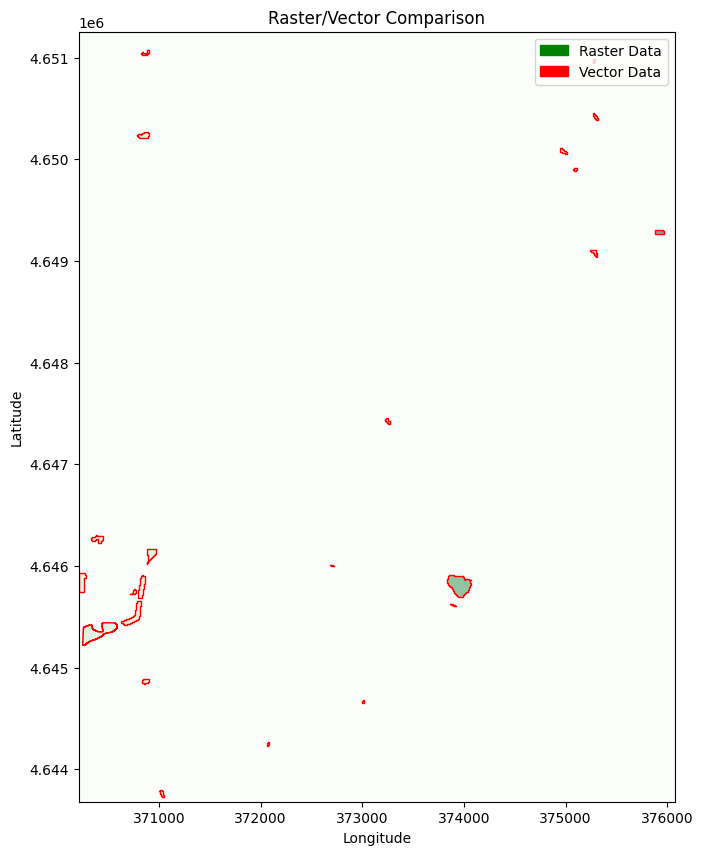

In [14]:
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def visualize_raster_vector(raster_path, vector_path):
    """
    Visualizes a raster dataset and a vector dataset on the same figure.

    Args:
    raster_path (str): The file path of the raster dataset (TIFF).
    vector_path (str): The file path of the vector dataset (Shapefile).
    """
    # Read the raster data
    with rasterio.open(raster_path) as src:
        raster_data = src.read(1)  # Read the first band
        # Capture raster transform and bounds for plotting
        transform = src.transform
        extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]

    # Read the vector data
    vector_data = gpd.read_file(vector_path)

    # Create a figure and axis for plotting
    fig, ax = plt.subplots(figsize=(10, 10), facecolor='white')

    # Plot the raster data using rio_show to avoid name conflicts
    raster_plot = show(raster_data, ax=ax, transform=transform, extent=extent, cmap='Greens', alpha=0.5)

    # Plot the vector data, saving the returned value for the legend
    vector_plot = vector_data.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)

    # Create legend
    raster_patch = mpatches.Patch(color='green', label='Raster Data')
    vector_patch = mpatches.Patch(color='red', label='Vector Data')
    plt.legend(handles=[raster_patch, vector_patch])

    # Set plot title and labels
    ax.set_title('Raster/Vector Comparison')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Show the plot
    plt.show()

# Example usage
raster_file_path = os.path.join(KC_MASK_ROOT, 'mask_m_4108804_ne_16_060_20210928.tif')
vector_file_path = os.path.join(KC_MASK_VEC_ROOT,'mask_m_4108804_ne_16_060_20210928.shp')
visualize_raster_vector(raster_file_path, vector_file_path)


### Storm Weather Geo-DataBase

In [6]:
class StormWeatherKC(VectorDataset):
    filename_glob = ""
    filename_regex = r"""
        ^mask_m
        _(?P<quadrangle>\d+)
        _(?P<quarter_quad>[a-z]+)
        _(?P<utm_zone>\d+)
        _(?P<resolution>\d+)
        _(?P<date>\d+)
        (?:_(?P<processing_date>\d+))?
        \..*$
    """

    label_names = {
        1: "POND",
        2: "WETLAND",
        3: "DRY BOTTOM - TURF",
        4: "DRY BOTTOM - MESIC PRAIRIE",
        5: "DEPRESSIONAL STORAGE",
        6: "DRY BOTTOM - WOODED",
        7: "POND - EXTENDED DRY",
        8: "PICP PARKING LOT",
        9: "DRY BOTTOM - GRAVEL",
        10: "UNDERGROUND",
        11: "UNDERGROUND VAULT",
        12: "PICP ALLEY",
        13: "INFILTRATION TRENCH",
        14: "BIORETENTION",
        15: "UNKNOWN",
    }

    labels_inverse = {v: k for k, v in label_names.items()}


### Fiona and Shape File exploration on Storm Weather Data (non-relevant with above)

Available Layers: The dataset comprises 51 layers, indicated by the layer numbers 1 through 51. Each layer potentially represents a different type of geospatial data, such as roads, water bodies, infrastructure, etc.

Layer Schema: For the layer 1 selected (layer 1), the schema shows the data structure of the features within this layer. It includes a variety of attributes like Id, GEOMETRY, MATERIAL, DIA_IN (diameter in inches), PERC_SLP (percent slope), CONDITION, among others. The geometry type for this layer is 3D MultiLineString, indicating that features are represented as multiline strings with a Z-coordinate (elevation or depth).

Sample Geometries and Properties: I printed the geometry and properties of the first few features in this layer (1). The geometries are 3D multiline strings, suggesting they likely represent linear features such as pipes or conduits with elevation data. However, the properties are shown as <fiona.model.Properties object at memory_address>, which suggests that the properties weren't directly printed. To view the properties, I would need to convert the Properties object into a readable format, typically by accessing its attributes or using a method like dict(feature['properties']).



In [5]:
### Exploration using fiona

import fiona
from shapely.geometry import shape

# Assuming the first item in your dataset index is the one you want to explore
dataset_path = os.path.join(KC_SHAPE_ROOT, 'KC_StormwaterDataJan2024.gdb.zip')

# Step 1: Open the dataset and list layers
with fiona.open(dataset_path, 'r') as gdb:
    print("Available layers:", list(gdb.keys()))

# Assuming you've selected a layer to explore, replace 'your_layer_name_here' with its actual name
layer_name = 4

# Step 2: Explore a specific layer
with fiona.open(dataset_path, layer=layer_name) as layer:
    # Print out schema to see attribute names and types
    print("Layer schema:", layer.schema)
    
    # Optionally, explore the first few features to understand their structure
    for feature in layer[:5]:  # Adjust the slice as needed
        geom = shape(feature['geometry'])
        props = feature['properties']
        print("Geometry:", geom)
        print("Properties:", props)



Available layers: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
Layer schema: {'properties': {'Function_': 'str:32', 'BasinType': 'str:32', 'Manmade': 'str:8', 'ADID': 'str:8', 'OwnerType': 'str:16', 'Owner': 'str:32', 'Outlet_Str': 'str:8', 'Last_Insp': 'datetime', 'Notes': 'str:72', 'AddUser': 'str:15', 'AddDate': 'datetime', 'EditUser': 'str:15', 'EditDate': 'datetime', 'Shape_STAr': 'float', 'Shape_STLe': 'float', 'Detention': 'str:12', 'Y_Built': 'int', 'JURISD': 'str:32', 'BASIN_ID': 'str:12', 'BASIN_NAME': 'str:32', 'INSP_RNFL': 'str:32', 'DATE_INSP': 'datetime', 'INSP_NAME': 'str:24', 'INSP_ORG': 'str:24', 'OUTLET_COND': 'str:24', 'OUTLET_NOTES': 'str:64', 'OUTLET_Q': 'str:24', 'SIDESLOPES': 'str:24', 'SS_NOTES': 'str:64', 'RIPRAP_TOE': 'str:12', 'SHORE_EROS': 'str:12', 'WETL_SHELF': 'str:12', 'AQUATIC_VEG': 'str:12', 'ALGAE_NOTES

#### Visualize the original dataset based on the Basin Type

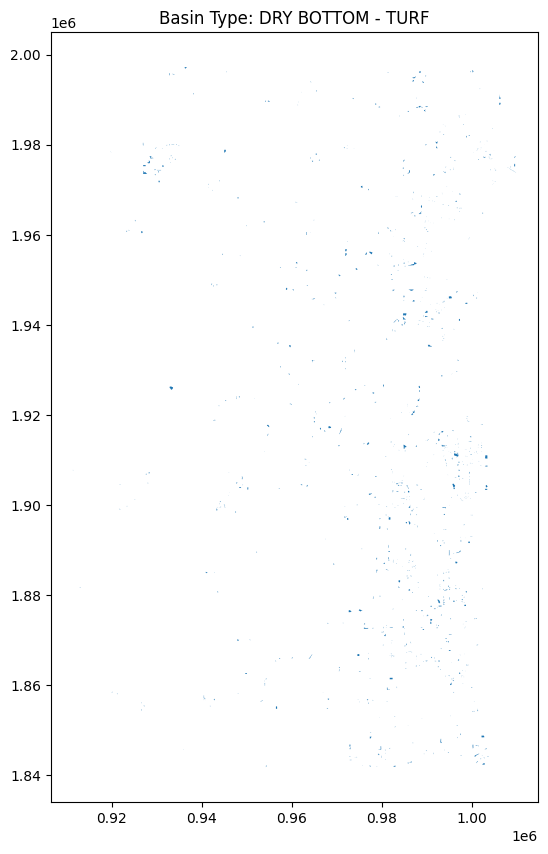

In [6]:
import fiona
from shapely.geometry import shape
import geopandas as gpd
import matplotlib.pyplot as plt

# Helper function to read a specific layer and return a GeoDataFrame
def read_layer_to_geodataframe(dataset_path, layer_name):
    features = []
    with fiona.open(dataset_path, layer=layer_name) as layer:
        for feature in layer:
            geom = shape(feature['geometry'])
            props = feature['properties']
            features.append({'geometry': geom, **props})
            
    return gpd.GeoDataFrame(features)

# Function to plot GeoDataFrame filtered by basin type
def plot_filtered_basin_type(dataset_path, layer_name, basin_type):
    gdf = read_layer_to_geodataframe(dataset_path, layer_name)
    
    # Filter the GeoDataFrame by the specified basin type
    filtered_gdf = gdf[gdf['BasinType'] == basin_type]
    
    # Plotting
    fig, ax = plt.subplots(figsize=(10, 10))
    filtered_gdf.plot(ax=ax)
    
    # Adding title for clarity
    plt.title(f'Basin Type: {basin_type}')
    plt.show()

# Assuming the first item in your dataset index is the one you want to explore
dataset_path = os.path.join(KC_SHAPE_ROOT, 'KC_StormwaterDataJan2024.gdb.zip')

# Assuming you've selected a layer to visualize
layer_name = 4
basin_type = 'DRY BOTTOM - TURF'  # Replace 'YourBasinTypeHere' with the actual basin type you want to filter and visualize

# Call the function with the dataset path, layer name, and basin type you want to visualize
plot_filtered_basin_type(dataset_path, layer_name, basin_type)


In [19]:
gdf = read_layer_to_geodataframe(dataset_path, 4)
gdf.head(5)

,geometry,Function_,BasinType,Manmade,ADID,OwnerType,Owner,Outlet_Str,Last_Insp,Notes,...,RET_WL_NOTES,PHRAGMITES,CATTAILS,MAINTENANCE,RETROFIT,WQ_FUNCTION,Aeration,FldStorage,Shape_Length,Shape_Area
0,"MULTIPOLYGON (((945992.273 1935539.526, 945981...",AGRICULTURAL,POND,YES,YES,PRIVATE,Landowner,,1899-12-30T00:00:01+00:00,Farm Pond,...,None,None,None,None,None,None,None,None,776.704786,26103.207615
1,"MULTIPOLYGON (((957439.997 1930555.492, 957416...",STORMWATER,DRY BOTTOM - TURF,YES,No,PRIVATE,,YES,1899-12-30T00:00:01+00:00,Stormwater basin north end of Sumerset Subdivi...,...,None,None,None,None,None,None,None,None,690.647980,28373.350311
2,"MULTIPOLYGON (((947040.816 1927034.962, 947028...",STORMWATER,POND,YES,No,PRIVATE,MULTIPLE LANDOWNERS,YES,1899-12-30T00:00:01+00:00,Sunset Views HOA,...,None,None,None,None,None,None,None,None,1390.440121,55652.573809
3,"MULTIPOLYGON (((948408.045 1926341.826, 948397...",STORMWATER,POND,YES,No,PRIVATE,MULTIPLE LANDOWNERS,YES,1899-12-30T00:00:01+00:00,Sunset Views HOA,...,None,None,None,None,None,None,None,None,1639.548970,76710.776685
4,"MULTIPOLYGON (((947424.509 1925889.426, 947443...",STORMWATER,POND,YES,NO,PRIVATE,Sunset Views HOA,YES,1899-12-30T00:00:01+00:00,Sunset Views HOA,...,None,None,None,None,None,None,None,None,2115.081120,116225.262790


The above shows the first five rows on the storm weather geodatabase, it has been successfully loaded by the fiona and could be later imported to the vectordataset class.